# Interest Rate Prediction removing outliers using IQR

In [812]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [813]:
train = pd.read_csv('Data/capstone_train.csv')
test = pd.read_csv('Data/capstone_test.csv')

In [814]:
combined_data = pd.concat((train,test))
combined_data = combined_data.drop(['Loan_ID'],axis = 1)

In [815]:
combined_data.isna().sum()[combined_data.isna().sum()!=0]/len(combined_data)

Length_Employed            0.044941
Home_Owner                 0.153588
Annual_Income              0.153369
Months_Since_Deliquency    0.537659
Interest_Rate              0.400004
dtype: float64

In [816]:
#Since we are having 53% of data missing in Months_Since_Deliquency we will convert this column into categorical since this column in important.

In [817]:
def deliq(x):
    if x==0:
        return 'No Deliquency Record'
    elif x>0 and x<=24:
        return 'High Deliquency Rate'
    elif x>24:
        return 'Low Deliquency Rate'
combined_data['Months_Since_Deliquency'] = combined_data['Months_Since_Deliquency'].fillna(0)
combined_data['Months_Since_Deliquency'] = combined_data['Months_Since_Deliquency'].apply(deliq)

In [818]:
#Convert Loan_Amt_Req to int
def loan_amt(x):
    return int(x.replace(',',''))
combined_data['Loan_Amount_Requested'] = combined_data['Loan_Amount_Requested'].apply(loan_amt)

In [819]:
#Looking for outliers

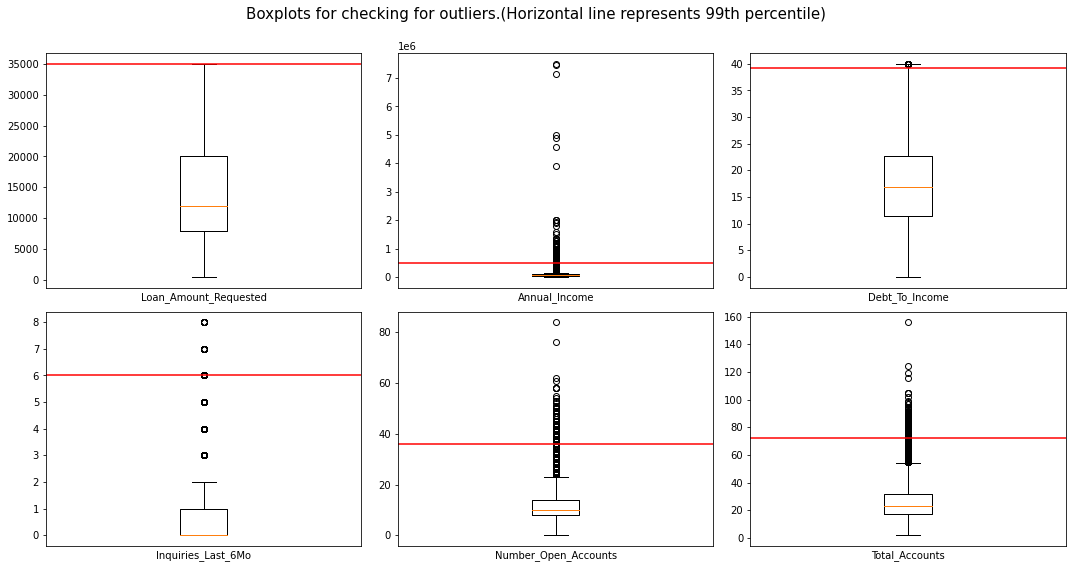

In [820]:
fig,ax = plt.subplots(nrows = 2,ncols = 3,figsize = (15,8))

for variables,plotsubs in zip(combined_data.select_dtypes(np.number).drop('Interest_Rate',axis =1).columns,ax.flatten()):
    
    plotsubs.tick_params(labelsize = 10)
    plotsubs.boxplot(combined_data[variables].dropna())
    plotsubs.axhline(combined_data[variables].quantile(0.999),color = 'r')
    plotsubs.set_xticks([])
    plotsubs.set_xlabel(variables,fontsize = 10)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.90)
    
fig.suptitle('Boxplots for checking for outliers.(Horizontal line represents 99th percentile)',fontsize = 15)
plt.show()

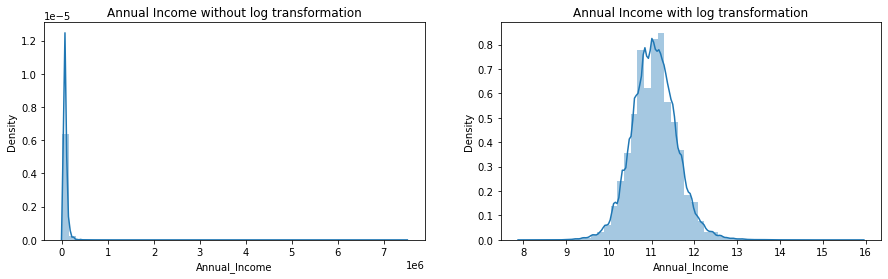

In [821]:
#Let us standardize the Annual_Income column first using log transformation
fig,ax = plt.subplots(1,2,figsize = (15,4))
sns.distplot(combined_data['Annual_Income'],ax = ax[0])
ax[0].set_title('Annual Income without log transformation')
sns.distplot(np.log(combined_data['Annual_Income']),ax = ax[1])
ax[1].set_title('Annual Income with log transformation')
plt.show()

In [822]:
combined_data['Annual_Income'] = np.log(combined_data['Annual_Income'])

##### Looking at boxplots after log trans of annual income

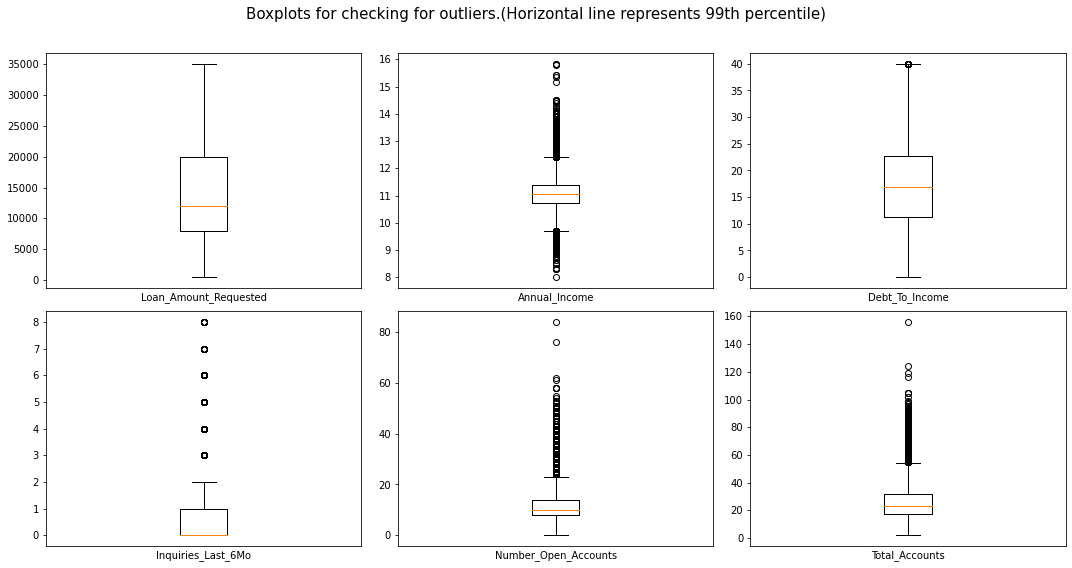

In [768]:
fig,ax = plt.subplots(nrows = 2,ncols = 3,figsize = (15,8))

for variables,plotsubs in zip(combined_data.select_dtypes(np.number).drop('Interest_Rate',axis =1).columns,ax.flatten()):
    
    plotsubs.tick_params(labelsize = 10)
    plotsubs.boxplot(combined_data[variables].dropna())
    plotsubs.set_xticks([])
    plotsubs.set_xlabel(variables,fontsize = 10)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.90)
    
fig.suptitle('Boxplots for checking for outliers.(Horizontal line represents 99th percentile)',fontsize = 15)
plt.show()

In [823]:
#Let us get rid of the outliers using the IQR method
data1 = combined_data.copy()
d = data1.drop('Interest_Rate',axis=1)
Q1 = d.quantile(0.25)
Q3 = d.quantile(0.75)
IQR = Q3-Q1
data1 = data1[~((data1<(Q1-1.5*IQR)) | (data1>(Q3+1.5*IQR))).any(axis = 1)]

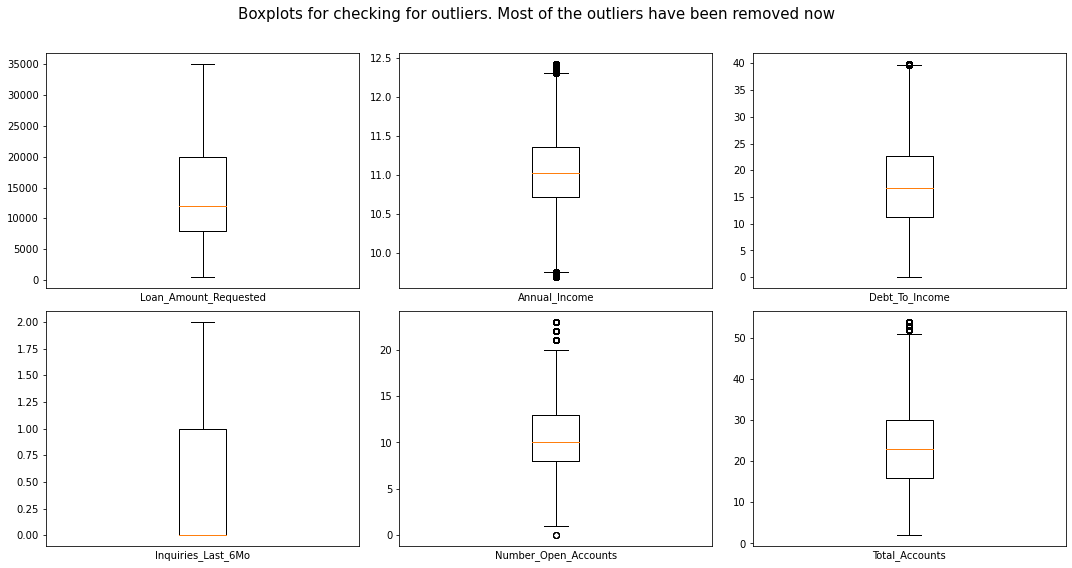

In [770]:
fig,ax = plt.subplots(nrows = 2,ncols = 3,figsize = (15,8))

for variables,plotsubs in zip(data1.select_dtypes(np.number).drop('Interest_Rate',axis =1).columns,ax.flatten()):
    
    plotsubs.tick_params(labelsize = 10)
    plotsubs.boxplot(data1[variables].dropna())
    plotsubs.set_xticks([])
    plotsubs.set_xlabel(variables,fontsize = 10)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.90)
    
fig.suptitle('Boxplots for checking for outliers. Most of the outliers have been removed now',fontsize = 15)
plt.show()

In [824]:
data1['Income_Verified'].value_counts()

VERIFIED - income           85131
not verified                78764
VERIFIED - income source    78087
Name: Income_Verified, dtype: int64

In [825]:
data1['Annual_Income'] = np.exp(data1['Annual_Income'])

In [826]:
def iverified(x):
    if x == 'not verified':
        return 'not verified'
    else:
        return 'verified'
data1['Income_Verified'] = data1['Income_Verified'].apply(iverified)

In [827]:
#Converting Length Employed into numerical
def len_emp(x):
    try:
        if x.split()[0].strip()=='<':
            return 1
        else:
            return x.strip('years').strip().strip('+')
    except:
        return np.nan
    
data1['Length_Employed'] = data1['Length_Employed'].apply(len_emp)

In [828]:
data1.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,7000,1,Rent,68000.0,not verified,car,18.37,0,No Deliquency Record,9,14,Female,1.0
1,30000,4,Mortgage,NaN,verified,debt_consolidation,14.93,0,High Deliquency Rate,12,24,Female,3.0
2,24725,7,Mortgage,75566.4,verified,debt_consolidation,15.88,0,No Deliquency Record,12,16,Male,3.0
4,17000,8,Own,96000.0,verified,debt_consolidation,22.17,1,No Deliquency Record,19,30,Female,1.0
5,4500,2,Rent,30000.0,verified,credit_card,10.88,1,No Deliquency Record,12,15,Male,3.0


In [829]:
data1['Home_Owner'].value_counts()

Mortgage    101806
Rent         84595
Own          18351
Other           72
None            19
Name: Home_Owner, dtype: int64

In [830]:
#Bucket Mortgage as one bucket and rent,own other and none in another bucket
def home_owner_bin(x):
    if x == 'Mortgage':
        return 'Mortgage'
    else:
        return 'Other'
data1['Home_Owner'] = data1['Home_Owner'].apply(home_owner_bin)

In [831]:
data1['Annual_Income'] #Fill later using KNNImputer

0          68000.0
1              NaN
2          75566.4
4          96000.0
5          30000.0
            ...   
109534         NaN
109537    125000.0
109538     37850.0
109539     30000.0
109540    137000.0
Name: Annual_Income, Length: 241982, dtype: float64

In [832]:
# data1[~(data1['Interest_Rate'].isna())].groupby('Purpose_Of_Loan').quantile(0.5)

In [833]:
data1['Purpose_Of_Loan'].unique()

array(['car', 'debt_consolidation', 'credit_card', 'home_improvement',
       'major_purchase', 'other', 'medical', 'small_business', 'moving',
       'wedding', 'vacation', 'educational', 'house', 'renewable_energy'],
      dtype=object)

In [834]:
#'Other': Wedding,vacation,small_business,renewable_energy,other,moving,medical
#'House'
#'Debt_Consolidation'
#'credit_card'
#'car'
#'home_improvement'
#'educational'
#'major_purchase'
def loan_purp(x):
    if x in ['other', 'medical', 'small_business', 'moving',
       'wedding', 'vacation','renewable_energy']:
        return 'other'
    elif x in ['car', 'debt_consolidation', 'credit_card','major_purchase']:
        return 'liabilities'
    else:
        return 'Assets'
data1['Purpose_Of_Loan'] = data1['Purpose_Of_Loan'].apply(loan_purp)

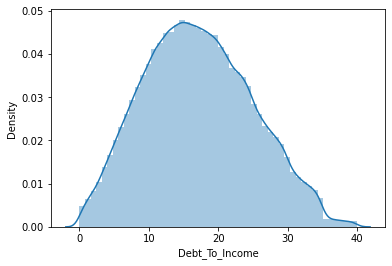

In [835]:
sns.distplot(data1['Debt_To_Income'])
plt.show()

In [836]:
#Bin Inquiries into yes and no
def Inq_6Mo(x):
    if x==0:
        return 'No Inquiry'
    else:
        return 'Inquired within 6 Mo'
data1['Inquiries_Last_6Mo']  = data1['Inquiries_Last_6Mo'].apply(Inq_6Mo)

In [837]:
data1.groupby('Interest_Rate')['Total_Accounts'].mean()

Interest_Rate
1.0    25.151609
2.0    23.629106
3.0    23.374985
Name: Total_Accounts, dtype: float64

In [838]:
data1['Number_Closed_Accounts'] = data1['Total_Accounts']-data1['Number_Open_Accounts']

In [839]:
data1.groupby('Interest_Rate')['Number_Closed_Accounts'].median()

Interest_Rate
1.0    13
2.0    12
3.0    11
Name: Number_Closed_Accounts, dtype: int64

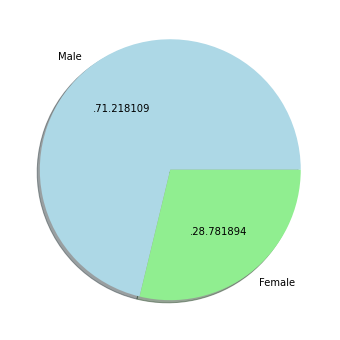

In [840]:
plt.figure(figsize = (15,6))
plt.pie(data1['Gender'].value_counts(),labels = ['Male','Female'],autopct = '.%f',shadow = True,colors = ['lightblue','lightgreen'])
plt.show()
#convert this to 1 and 0 for model

### Statistical Analysis

In [841]:
data1.describe().T

,count,mean,std,min,25%,50%,75%,max
Loan_Amount_Requested,241982.0,14229.956464,8150.640280,500.0,8000.00,12000.00,20000.00,35000.00
Annual_Income,204363.0,69646.575098,35185.578454,16200.0,45000.00,61200.00,85000.00,247500.00
Debt_To_Income,241982.0,17.149423,7.807604,0.0,11.32,16.76,22.67,39.91
Number_Open_Accounts,241982.0,10.692113,4.257864,0.0,8.00,10.00,13.00,23.00
Total_Accounts,241982.0,23.874284,10.208999,2.0,16.00,23.00,30.00,54.00
Interest_Rate,145277.0,2.135713,0.737741,1.0,2.00,2.00,3.00,3.00
Number_Closed_Accounts,241982.0,13.182171,8.150657,-6.0,7.00,12.00,18.00,49.00


In [842]:
data1.select_dtypes('object').describe().T

,count,unique,top,freq
Length_Employed,231362,11,10,78252
Home_Owner,241982,2,Other,140176
Income_Verified,241982,2,verified,163218
Purpose_Of_Loan,241982,3,liabilities,205923
Inquiries_Last_6Mo,241982,2,No Inquiry,137160
Months_Since_Deliquency,241982,3,No Deliquency Record,131864
Gender,241982,2,Male,172335


In [843]:
data1.select_dtypes(np.number).columns

Index(['Loan_Amount_Requested', 'Annual_Income', 'Debt_To_Income',
       'Number_Open_Accounts', 'Total_Accounts', 'Interest_Rate',
       'Number_Closed_Accounts'],
      dtype='object')

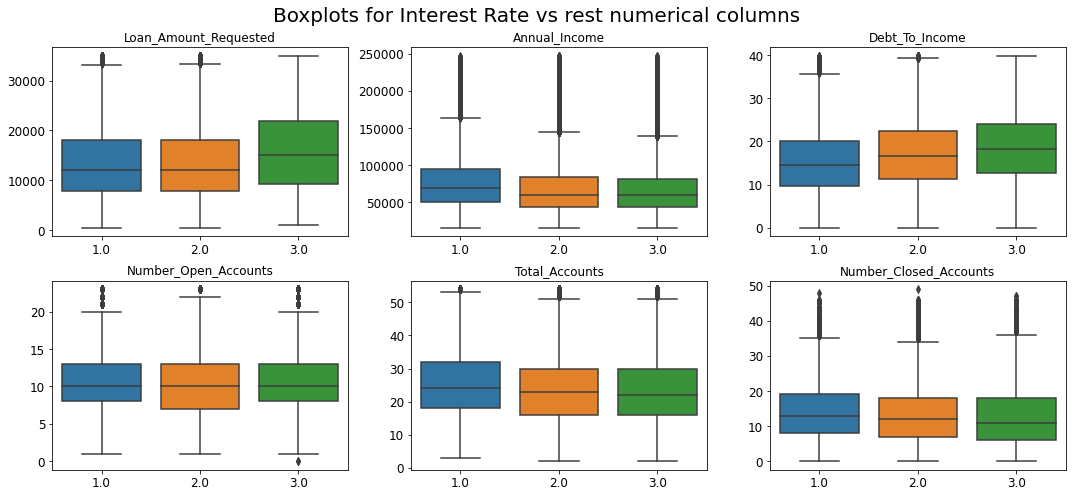

In [844]:
fig,ax = plt.subplots(nrows = 2,ncols = 3,figsize = (15,7))

for variables,plotsubs in zip(data1.drop('Interest_Rate',axis =1).select_dtypes(np.number),ax.flatten()):
    plotsubs.tick_params(labelsize = 12)
    plotsubs.set_title(variables,fontsize = 12)
    sns.boxplot(data1['Interest_Rate'],data1[variables],ax = plotsubs)
    plotsubs.set_xlabel('')
    plotsubs.set_ylabel('')
    plt.tight_layout()
    plt.subplots_adjust(top = 0.90)
    
fig.suptitle('Boxplots for Interest Rate vs rest numerical columns',fontsize = 20)
plt.show()

In [845]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
model = ols("Interest_Rate~Loan_Amount_Requested+Months_Since_Deliquency+Number_Open_Accounts+Annual_Income+Debt_To_Income+Total_Accounts+Number_Closed_Accounts",data1).fit()
sm.stats.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
Months_Since_Deliquency,2.0,918.120741,459.060371,931.275616,0.000000e+00
Loan_Amount_Requested,1.0,1299.094271,1299.094271,2635.415503,0.000000e+00
Number_Open_Accounts,1.0,125.754446,125.754446,255.112523,2.279449e-57
Annual_Income,1.0,2352.544596,2352.544596,4772.503917,0.000000e+00
Debt_To_Income,1.0,841.876180,841.876180,1707.877238,0.000000e+00
Total_Accounts,1.0,735.941957,735.941957,1492.973131,0.000000e+00
Number_Closed_Accounts,1.0,0.394744,0.394744,0.800800,3.708559e-01
Residual,122780.0,60522.826284,0.492937,NaN,NaN


In [846]:
sm.stats.anova_lm(model)['PR(>F)']>0.05

Months_Since_Deliquency    False
Loan_Amount_Requested      False
Number_Open_Accounts       False
Annual_Income              False
Debt_To_Income             False
Total_Accounts             False
Number_Closed_Accounts      True
Residual                   False
Name: PR(>F), dtype: bool

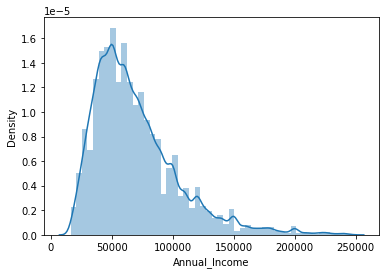

In [847]:
sns.distplot(data1['Annual_Income'])
plt.show()

In [848]:
categorical_cols = data1.select_dtypes('object').drop('Months_Since_Deliquency',axis = 1).columns
categorical_cols

Index(['Length_Employed', 'Home_Owner', 'Income_Verified', 'Purpose_Of_Loan',
       'Inquiries_Last_6Mo', 'Gender'],
      dtype='object')

### Applying KNNImputer

In [849]:
data1.to_csv('Data/Other_Approach.csv',index = False)

In [852]:
data_1 = pd.read_csv('Data/Other_Approach.csv')
data1 = data_1[~(data_1['Interest_Rate'].isna())].copy()
data1.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate,Number_Closed_Accounts
0,7000,1.0,Other,68000.0,not verified,liabilities,18.37,No Inquiry,No Deliquency Record,9,14,Female,1.0,5
1,30000,4.0,Mortgage,NaN,verified,liabilities,14.93,No Inquiry,High Deliquency Rate,12,24,Female,3.0,12
2,24725,7.0,Mortgage,75566.4,verified,liabilities,15.88,No Inquiry,No Deliquency Record,12,16,Male,3.0,4
3,17000,8.0,Other,96000.0,verified,liabilities,22.17,Inquired within 6 Mo,No Deliquency Record,19,30,Female,1.0,11
4,4500,2.0,Other,30000.0,verified,liabilities,10.88,Inquired within 6 Mo,No Deliquency Record,12,15,Male,3.0,3


In [853]:
data1 = data1.drop('Months_Since_Deliquency',axis = 1)

In [854]:
for i in categorical_cols:
    data1[i] = data1[i].replace(data1[i].dropna().unique(),range(len(data1[i].dropna().unique())))

In [855]:
data1.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate,Number_Closed_Accounts
0,7000,0.0,0,68000.0,0,0,18.37,0,9,14,0,1.0,5
1,30000,1.0,1,NaN,1,0,14.93,0,12,24,0,3.0,12
2,24725,2.0,1,75566.4,1,0,15.88,0,12,16,1,3.0,4
3,17000,3.0,0,96000.0,1,0,22.17,1,19,30,0,1.0,11
4,4500,4.0,0,30000.0,1,0,10.88,1,12,15,1,3.0,3


In [856]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
data_scaled = ss.fit_transform(data1)
data_scaled = pd.DataFrame(data_scaled,columns = data1.columns)
data_scaled.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate,Number_Closed_Accounts
0,-0.887202,-1.608583,-0.852102,-0.046549,-1.441855,-0.396455,0.157763,-0.872817,-0.395729,-0.966588,-1.576398,-1.539451,-1.003804
1,1.936284,-1.235997,1.173569,NaN,0.693551,-0.396455,-0.282500,-0.872817,0.307824,0.013188,-1.576398,1.171535,-0.144590
2,1.288724,-0.863412,1.173569,0.168306,0.693551,-0.396455,-0.160916,-0.872817,0.307824,-0.770633,0.634358,1.171535,-1.126548
3,0.340401,-0.490826,-0.852102,0.748539,0.693551,-0.396455,0.644101,1.145716,1.949448,0.601054,-1.576398,-1.539451,-0.267335
4,-1.194102,-0.118241,-0.852102,-1.125598,0.693551,-0.396455,-0.800834,1.145716,0.307824,-0.868610,0.634358,1.171535,-1.249293


In [857]:
from sklearn.impute import KNNImputer
knn_imp = KNNImputer(n_neighbors = 10)
data_filled = knn_imp.fit_transform(data_scaled)
data_unscaled = pd.DataFrame(ss.inverse_transform(data_filled).round,columns = data_scaled.columns)
data_filled = data_unscaled.apply(round).copy()

In [868]:
data_filled = data_unscaled.apply(round)

In [874]:
for i in categorical_columns:
    data_filled[i] = data_filled[i].replace(data_filled[i].unique(),data_1[i].dropna().unique())

In [878]:
final_data = pd.concat((data_filled,data_1['Months_Since_Deliquency']),axis = 1,join='inner')

In [881]:
final_data.to_csv('Data/Other_Approach_filled.csv',index = False)

# Data Filled

In [882]:
final_data = pd.read_csv('Data/Other_Approach_filled.csv')
final_data.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate,Number_Closed_Accounts,Months_Since_Deliquency
0,7000.0,1.0,Other,68000.0,not verified,liabilities,18.0,No Inquiry,9.0,14.0,Female,1.0,5.0,No Deliquency Record
1,30000.0,4.0,Mortgage,72840.0,verified,liabilities,15.0,No Inquiry,12.0,24.0,Female,3.0,12.0,High Deliquency Rate
2,24725.0,7.0,Mortgage,75566.0,verified,liabilities,16.0,No Inquiry,12.0,16.0,Male,3.0,4.0,No Deliquency Record
3,17000.0,8.0,Other,96000.0,verified,liabilities,22.0,Inquired within 6 Mo,19.0,30.0,Female,1.0,11.0,No Deliquency Record
4,4500.0,2.0,Other,30000.0,verified,liabilities,11.0,Inquired within 6 Mo,12.0,15.0,Male,3.0,3.0,No Deliquency Record


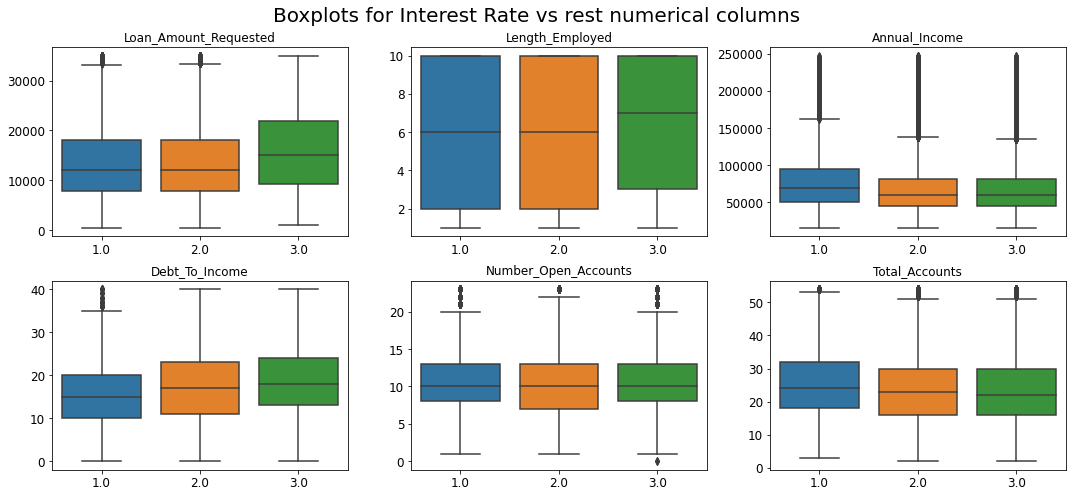

In [883]:
fig,ax = plt.subplots(nrows = 2,ncols = 3,figsize = (15,7))
data1 = final_data
for variables,plotsubs in zip(data1.drop('Interest_Rate',axis =1).select_dtypes(np.number),ax.flatten()):
    plotsubs.tick_params(labelsize = 12)
    plotsubs.set_title(variables,fontsize = 12)
    sns.boxplot(data1['Interest_Rate'],data1[variables],ax = plotsubs)
    plotsubs.set_xlabel('')
    plotsubs.set_ylabel('')
    plt.tight_layout()
    plt.subplots_adjust(top = 0.90)
    
fig.suptitle('Boxplots for Interest Rate vs rest numerical columns',fontsize = 20)
plt.show()

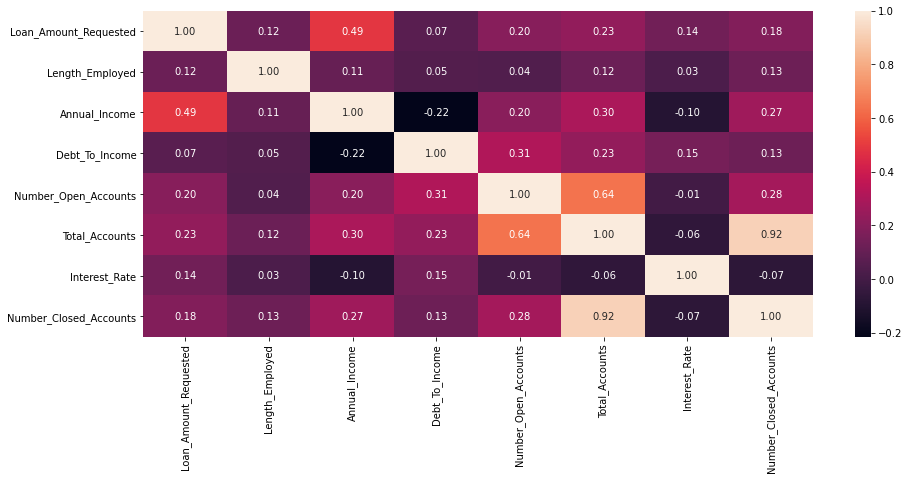

In [888]:
plt.figure(figsize = (15,6))
sns.heatmap(final_data.corr(),annot = True,fmt = '.2f')
plt.show()

### Standardizing the dataset

In [902]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
n = final_data.select_dtypes(np.number).drop('Interest_Rate',axis = 1)
num_data = pd.DataFrame(ss.fit_transform(n),columns = n.columns)

In [906]:
final_std = pd.concat((num_data,final_data.select_dtypes('object'),final_data['Interest_Rate']),axis = 1)

# Model Building

In [915]:
df_scaled = pd.get_dummies(final_std.drop('Total_Accounts',axis = 1),drop_first = True)
df = pd.get_dummies(final_data.drop('Total_Accounts',axis = 1),drop_first = True)

In [930]:
df.columns

Index(['Loan_Amount_Requested', 'Length_Employed', 'Annual_Income',
       'Debt_To_Income', 'Number_Open_Accounts', 'Interest_Rate',
       'Number_Closed_Accounts', 'Home_Owner_Other',
       'Income_Verified_verified', 'Purpose_Of_Loan_liabilities',
       'Purpose_Of_Loan_other', 'Inquiries_Last_6Mo_No Inquiry', 'Gender_Male',
       'Months_Since_Deliquency_Low Deliquency Rate',
       'Months_Since_Deliquency_No Deliquency Record'],
      dtype='object')

### Train test split

In [939]:
from sklearn.model_selection import train_test_split
X = df.drop(['Interest_Rate'],axis =1)
y = df['Interest_Rate']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 2)

In [940]:
from sklearn.model_selection import train_test_split
X1 = df_scaled.drop(['Interest_Rate'],axis =1)
y1 = df_scaled['Interest_Rate']
X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y1,test_size = 0.2,random_state = 2)

### Logistic Regression

In [941]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter = 200)
lr.fit(X1_train,y1_train)
lr.score(X1_test,y1_test)

0.5153840859030837

### Base Function for all models with confusion matrix

In [942]:
def model_function(model,X_train,X_test,y_train,y_test):
    #Fitting the model
    model = model
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print('*'*95)
    print("\n"+"\033[1m"+'Model Report for '+str(model)+"\033[0;0m"+"\n")
    print('*'*95)

    #Performance metrics
    from sklearn.metrics import classification_report
    print(classification_report(y_test,y_pred))

    #Confusion_Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize = (15,6))
    sns.heatmap(cm,annot = True,fmt = '.2f')
    plt.title('Confusion Matrix')
    plt.xticks([0.5,1.5,2.5],[1,2,3])
    plt.yticks([0.5,1.5,2.5],[1,2,3])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def grid_search(estimator,params,X_train,y_train,cv=5,v=0):
    from sklearn.model_selection import GridSearchCV
    grid = GridSearchCV(estimator,params,scoring = 'roc_auc',n_jobs = -1,cv = cv,verbose = v)
    grid.fit(X_train,y_train)
    return grid.best_params_

### DecisionTreeClassifier

***********************************************************************************************

Model Report for DecisionTreeClassifier()

***********************************************************************************************
              precision    recall  f1-score   support

         1.0       0.32      0.33      0.32      6268
         2.0       0.46      0.45      0.45     12698
         3.0       0.45      0.45      0.45     10090

    accuracy                           0.42     29056
   macro avg       0.41      0.41      0.41     29056
weighted avg       0.42      0.42      0.42     29056



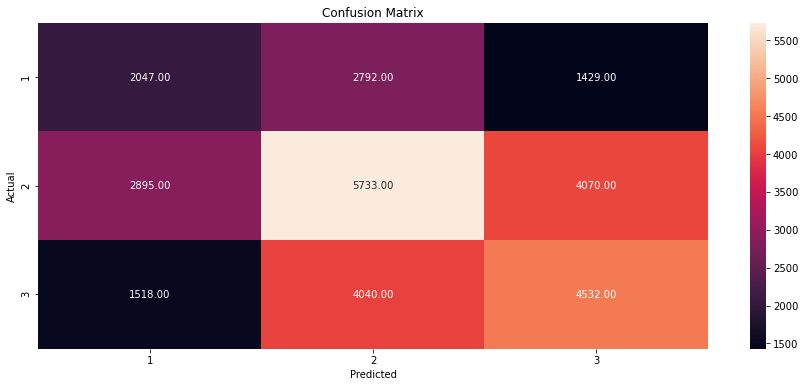

In [943]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
model_function(dtc,X1_train,X1_test,y1_train,y1_test)

### ExtraTreesClassifier

***********************************************************************************************

Model Report for ExtraTreesClassifier()

***********************************************************************************************
              precision    recall  f1-score   support

         1.0       0.46      0.27      0.34      6268
         2.0       0.49      0.60      0.54     12698
         3.0       0.53      0.51      0.52     10090

    accuracy                           0.50     29056
   macro avg       0.49      0.46      0.47     29056
weighted avg       0.50      0.50      0.49     29056



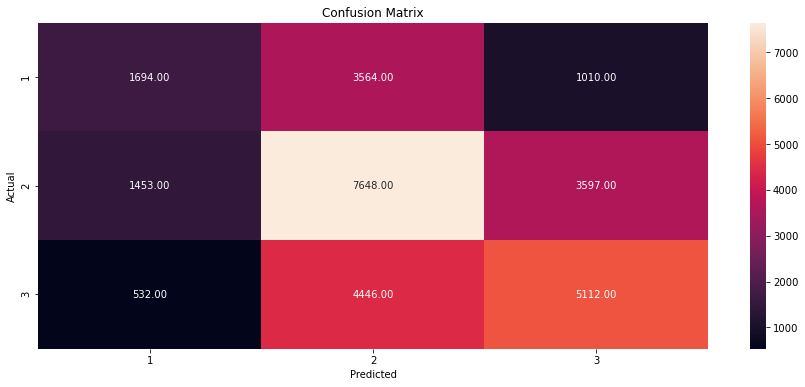

In [945]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()
model_function(etc,X_train,X_test,y_train,y_test)

### RandomForestClassifier

***********************************************************************************************

Model Report for RandomForestClassifier(n_estimators=1000)

***********************************************************************************************
              precision    recall  f1-score   support

         1.0       0.49      0.26      0.34      6268
         2.0       0.50      0.62      0.55     12698
         3.0       0.54      0.52      0.53     10090

    accuracy                           0.51     29056
   macro avg       0.51      0.47      0.48     29056
weighted avg       0.51      0.51      0.50     29056



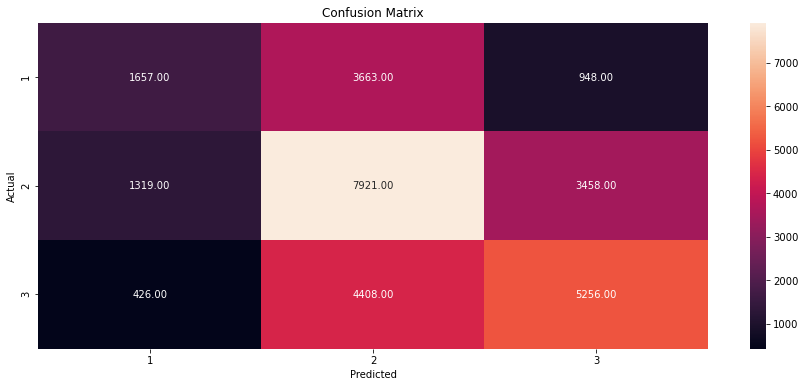

In [946]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 100)
model_function(rfc,X_train,X_test,y_train,y_test)

### AdaBoostClassifier

***********************************************************************************************

Model Report for AdaBoostClassifier()

***********************************************************************************************
              precision    recall  f1-score   support

         1.0       0.54      0.22      0.32      6268
         2.0       0.50      0.68      0.57     12698
         3.0       0.57      0.52      0.54     10090

    accuracy                           0.52     29056
   macro avg       0.54      0.47      0.48     29056
weighted avg       0.53      0.52      0.51     29056



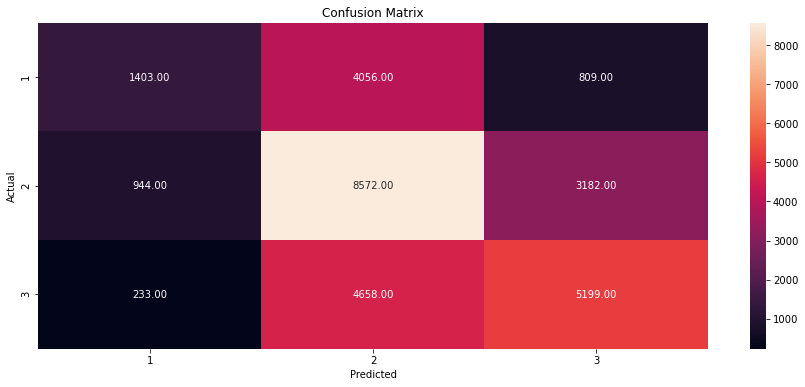

In [949]:
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier()
model_function(adb,X1_train,X1_test,y1_train,y1_test)

### XGBClassifier

[18:33:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
***********************************************************************************************

Model Report for XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_met

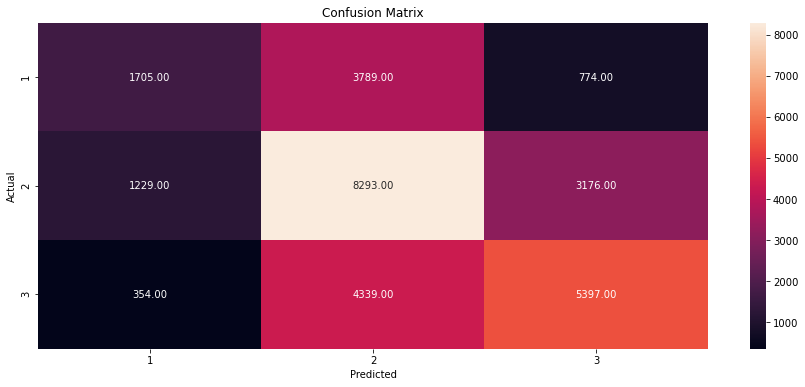

In [952]:
import xgboost as xgb
from xgboost import XGBClassifier
xgbc = XGBClassifier()
model_function(xgbc,X_train,X_test,y_train,y_test)

### CatBoostClassifier

***********************************************************************************************

Model Report for <catboost.core.CatBoostClassifier object at 0x000001BF8529C2C8>

***********************************************************************************************
              precision    recall  f1-score   support

         1.0       0.52      0.27      0.36      6268
         2.0       0.50      0.65      0.57     12698
         3.0       0.57      0.53      0.55     10090

    accuracy                           0.53     29056
   macro avg       0.53      0.49      0.49     29056
weighted avg       0.53      0.53      0.52     29056



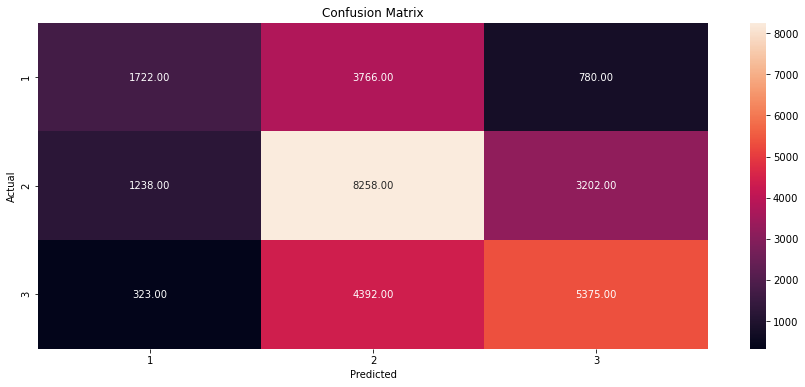

In [953]:
from catboost import CatBoostClassifier
cbc = CatBoostClassifier(verbose = 0)
model_function(cbc,X_train,X_test,y_train,y_test)